# Homework set 11 Comp Econ
## Replication of fig. 1 from Kamihigashi and Stachurski (*Theoretical Economics* 9 (2014))

**Author** Pierre Mabille 

**NYU ID** N10017621 

**Date** May 13, 2016 

This section 
* imports packages used along the way, in particular a series of modules from QuantEcon that make iterations on thew Bellman equation easier. 
* defines a type "planner problem" for this kind of problems, and the outer constructor for that type. 
* defines a function that performs the integration step when computing the expectation in the Belmann equation, $$ v(y_t) = \max_{c_t \in (0,y_t)} u(c_t) + \beta \mathbb{E}\left[ v\left(\xi_{t+1}f(y_t-c_t) \right) \right],$$ where $\xi$ is an iid lognormal(-0.1,0.2) shock. The expectation is computed by quadrature or MC method (using 1,000 draws by default). 

In [1]:
using Distributions
using QuantEcon: qnwlogn, qnwlege, do_quad, compute_fixed_point, LAE, lae_est
using Interpolations
using Optim: optimize, Brent, GoldenSection
using PyPlot

function logistic(x, a =1, b=2, c = 20, d = 1)
    a + (b-a) * 1./( 1 + exp(-c * (x-d) ) )
end

type PlannerProb

    β::Float64
    u::Function
    f::Function

    grid::AbstractVector

    phi::Distribution
    quad_nodes::Vector
    quad_weights::Vector
    ξ_samp::Vector

    v::Vector{Float64}
    σ::Vector{Float64}

end

function PlannerProblem(β; γ = 0.9, θ = 0.5, α = 0.5, mu =-0.1, sig = sqrt(0.2),
                        grid_max = 8, grid_size = 120)

# γ = 0.9; θ = 0.5; α = 0.5; mu =-0.1; sig = 0.2
# grid_max = 30; grid_size = 200
    #== Functions ==#
    u(c) = 1 - exp(-θ * c.^γ )
    f(s) = (s.^α) .* (logistic(s))

    #== Grid ==#
    # grid1 = linspace(1e-8, 3.0, 3*div(grid_size,4))
    # grid2 = linspace(3.0, grid_max, div(grid_size,4)+1)
    # grid  = [collect(grid1); collect(grid2[2:end])]

    # grid = powerspacegrid(1e-5, grid_max, grid_size, 0.5)
    grid = linspace(1e-8, grid_max, grid_size)

    #== ξ distribution and nodes for ∫ ==#
    phi     = LogNormal(mu, sig)
    sig_phi = std(phi)
    _int_min, _int_max = 0.5, 3.5 #exp(mu + 3 * sig)
    n, w = qnwlege(30, _int_min, _int_max)

    ξ_samp = rand(phi,1000)

    #== Value function & policy ==#
    v = zeros(grid)
    σ = copy(grid)

    PlannerProb(β, u, f, grid, phi, n, w, ξ_samp, v, σ)
end


function integrate(pp::PlannerProb, g::Function, use_quad::Bool,
                   qn::Array=pp.quad_nodes, qw::Array=pp.quad_weights)


    if use_quad
        #== Compute Integral with quad ==#
        int_func(x) = g(x) .* pdf(pp.phi, x)
        return do_quad(int_func, qn, qw)
    else
        #== Compute Integral with Mc ==#
        ξ = pp.ξ_samp
        return mean(g(ξ))
        # == Deterministic case ==#
        # return g(1.0)

    end
end

integrate (generic function with 3 methods)

This section builds on QuantEcon routines. 
* It defines the Bellman operator of the problem using the data (fields) from a concrete instance of the type "Planner problem". The value function on the RHS is linearly interpolated using the grid points. We define the objective function to maximize (its opposite to minimize) in current consumption $c$ and use optimization methods from the Optim package for the minimization step. The Bellman operator returns the value fucntion, or the optimal consumption policy function depending on the grid points for current inventories $y$. 
* The function policy_operator taes this optimal consumption function and plugs it in the Bellman equation to obtain the new value function when we iterate one time on the Bellman equation.
* The function compute_σ_howard implements the Howward improvement step using the latter two functions.

Results are stored in the fields of the concrete instance of the type "Planner problem", which is updated.

In [6]:
function bellman_operator(pp::PlannerProb, v::Vector; ret_policy=false, use_quad = false)

    ret_policy ? (out = zeros(pp.σ)) : (out = zeros(v))
    bellman_operator!(pp, v, out, ret_policy=ret_policy, use_quad = use_quad)
    return out
end

function bellman_operator!(pp, v, out; ret_policy = false, use_quad = false)

    u, f, β = pp.u, pp.f, pp.β
    grid = pp.grid

    c_min = 0.0

    # Lv(y) = interpolate((collect(grid),), v, Gridded(Linear()) )[y]
    itp  = interpolate((collect(grid),), v, Gridded(Linear()) )
    itp2 = extrapolate(itp, Flat())
    Lv(y)    = itp2[y]

    for (i,x) in enumerate(grid)
        function obj(c)
            to_integrate(ξ) = Lv( ξ * f(x - c) )
            return -u(c)  - β * integrate(pp, to_integrate, use_quad)
        end
        rgl = optimize(obj, c_min, x, method = GoldenSection())
        rbr  = optimize(obj, c_min, x, method = Brent())

        (rbr.f_minimum < rgl.f_minimum) ? (res = rbr) : (res = rgl)
        # res = rgl

        if ret_policy
            out[i] =   res.minimum
        else
            out[i] = - res.f_minimum
        end
    end
end

function policy_operator!(pp::PlannerProb, v::AbstractVector, Tv::AbstractVector; use_quad::Bool=false)

    u, f, β  = pp.u, pp.f, pp.β
    grid, σ  = pp.grid, pp.σ

    # grid_int = collect(grid)
    itp  = interpolate((collect(grid),), v, Gridded(Linear()) )
    itp2 = extrapolate(itp, Flat())
    Lv(y)    = itp2[y]

    for (i, x) in enumerate(grid)
        to_integrate(ξ) = Lv( ξ * f( x - σ[i] ) )
        Tv[i] = u( σ[i] ) + β * integrate(pp, to_integrate, use_quad)
    end

end

function policy_operator(pp::PlannerProb, v::AbstractVector; use_quad::Bool = false)

    Tv = zeros(v)
    policy_operator!(pp, v, Tv; use_quad = use_quad)
    return Tv
end

function compute_σ_howard(pp::PlannerProb; use_quad::Bool = false, pol_tol = 1e-6, max_it = 100)


    #== Use quadrature to compute Exp ==#

    #== Bellman oper ==#
    bellman_oper0(v, pol) = bellman_operator(pp, v; ret_policy=pol, use_quad = true)
    bellman_oper(v, pol)  = bellman_operator(pp, v; ret_policy=pol, use_quad = use_quad) # set ret policy true

    #== Values ==#
    v_init  = copy(pp.v)  # Initial condition
    v_new   = copy(pp.v)

    #== Policies ==#
    # σ_old  = copy(pp.σ)

    it = 1
    dist = 1

    #== Iterate a little on Bellman ==#
    println("Initial iterations on Bellman")
    for j =1:100
        v_init = bellman_oper0(v_init,false)
    end

    copy!(pp.σ, bellman_oper0(v_init, true))

    while dist>pol_tol && it<=max_it

        @printf("ITERATION %02d \n", it)
        println("--------------------------------------------------------------")
        #== Policy operator ==#
        pol_oper(v_σ) = policy_operator(pp, v_σ, use_quad = use_quad)  # defined inside for bc pp.σ updates

        #== Policy value function ==#
        vσ = compute_fixed_point(pol_oper, v_init; err_tol=1e-8, max_iter=1000, verbose=true, print_skip=50)

        σ_new = bellman_oper(vσ, true)
        v_new = bellman_oper(vσ, false)

        #== comment ==#
        # dist = maximum(abs(pp.σ - σ_new))
        dist = maximum(abs(v_init - v_new))

        #== Update on pp ==#
        copy!(pp.σ, σ_new)
        copy!(v_init,vσ)
        @printf("ERROR: %.6f\n", dist)
        println("..............................................................\n")
        it += 1
    end

    #== Update value function on pp ==#
    copy!(pp.v, v_new)

    return Void
end

compute_σ_howard (generic function with 1 method)

This section defines a function computing the stationary distribution of the state variable $y$ for various values of $\beta$.

In [7]:
function asymp_ψ(pp::PlannerProb,ygrid::AbstractVector)

    grid, σ = pp.grid, pp.σ
    phi     = pp.phi

    #== Interpolation ==#
    σpol(y)  = interpolate((collect(grid),), σ, Gridded(Linear()) )[y]
    function p(x, y)
        #=
        Stochastic kernel for model.
        Both x and y must be strictly positive.
        =#
        d = pp.f( x - σpol(x))

        # scipy silently evaluates the pdf of the lognormal dist at a negative
        # value as zero. It should be undefined and Julia recognizes this.
        pdf_arg = clamp(y ./ d, eps(), Inf)
        return pdf(phi, pdf_arg)  ./ d
    end

    n = 1000    # Number of observations at each date t
    T = 51      # Compute density of k_t at 1,...,T+1

    # Generate matrix s.t. t-th column is n observations of k_t
    y = Array(Float64, n, T)
    ξ = rand!(phi, Array(Float64, n, T))

    # Draw first column from initial distribution
    # match scale=0.5 and loc=2*i in python version
    y[:, 1] = 1.0
    for t=1:T-1
        y[:, t+1] = ξ[:, t] .* pp.f( y[:,t] - σpol(y[:,t]) )
    end
    # Generate T instances of LAE using this data, one for each date t
    laes = LAE(p, y[:, T])
    # laes = [LAE(p, y[:, t]) for t=T:-5:1]

    # fig, ax = subplots(figsize = (8,8))
    # greys = [string(g) for g in linspace(0.0, 1.0, T)]
    # for (psi, g) in zip(laes, greys)
        # ax[:plot](ygrid, lae_est(psi, ygrid), color=g, lw=4, alpha=0.6)
    # end
    # ax[:set_xlabel]("y")
    # ax[:set_xlim]([0,2.0])
    return lae_est(laes, ygrid)
end

asymp_ψ (generic function with 1 method)

Finally, this section generates a collection of planner problems for a series of $\beta$s as in fig. 1 of the paper. For each of those, we plot the stationary distribution inventories $y$ computed with the function defined above. That is the point of the code where all functions defined above are called. 

The distributions display the same shapes as those of fig. 1.

In [8]:
βvals = collect(0.94:0.01:0.98)
pps = PlannerProb[PlannerProblem(β;  sig = 0.2, mu =-0.1, grid_size = 100)
                for β in βvals];

Initial iterations on Bellman
ITERATION 01 
--------------------------------------------------------------
Compute iterate 50 with error 0.00018476845964698896
Compute iterate 100 with error 4.236330318985182e-6
Compute iterate 150 with error 1.9203593204508707e-7
Converged in 198 steps
ERROR: 0.132457
..............................................................

ITERATION 02 
--------------------------------------------------------------
Compute iterate 50 with error 8.752751814089521e-5
Compute iterate 100 with error 2.217051788377944e-6
Compute iterate 150 with error 5.620920973115062e-8
Converged in 174 steps
ERROR: 0.051402
..............................................................

ITERATION 03 
--------------------------------------------------------------
Compute iterate 50 with error 1.1837794300362248e-7
Converged in 84 steps
ERROR: 0.000126
..............................................................

ITERATION 04 
----------------------------------------------------

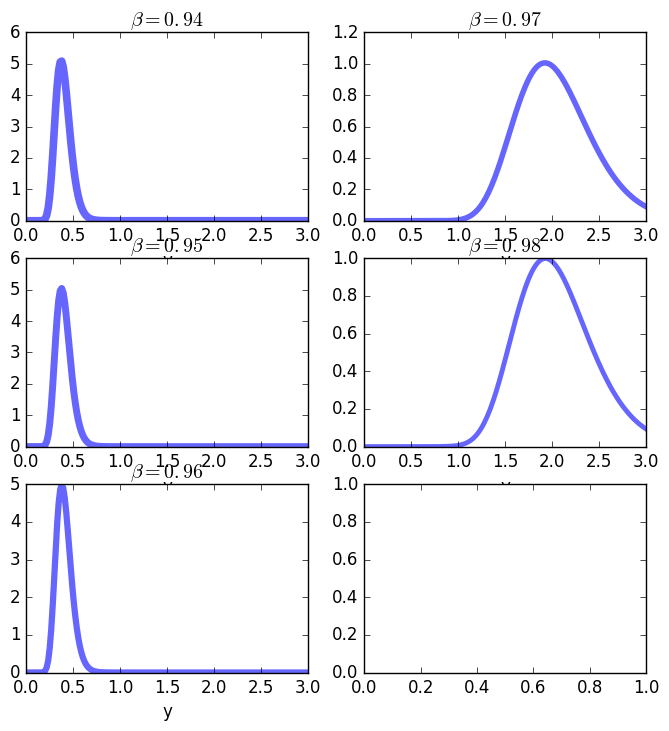

In [10]:
xmax = 8.0
ygrid = linspace(0.01, xmax, 500)

fig, axes = subplots(3,2,figsize = (8,8))

for i = 1:length(βvals)
    pp = pps[i]

    #== Compute policy ==#
    compute_σ_howard(pp; use_quad = false)
    #== Asymptotic dist ==#
    ψ = asymp_ψ(pp, ygrid)

    ax = axes[i]
    ax[:set_xlim](0, 3.0)
    ax[:set_title](latexstring("\\beta = $(βvals[i])"))
    ax[:set_xlabel]("y")
    ax[:plot](ygrid, ψ, lw=6-i*0.5, alpha=0.6)
    ax[:legend](ncol = 2)
end
